In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
SIZE = 30

In [3]:
def next_frame(last_row, column, size, radius=3):
    # This is the frame to be returned
    frame = np.zeros((size, size))
    # Define vertical boundries, so the ball does not go out of the frame
    lower = max(0, last_row - radius)
    upper = min(frame.shape[0] - 1, last_row + radius)
    # Pick a random row
    row = random.randint(lower, upper)
    # Draw the ball
    cv2.circle(frame, (column, row), radius, 255, -1)
    return frame, row

In [4]:
def build_frames(size, radius=3):
    frames = []
    row = random.randint(0, size - 1)
    # Decide whether the ball moves to the right or left
    rand = random.random()
    right = 1 if rand >= 0.5 else 0
    column = 0 if right == 1 else size - 1

    for i in range(size):
        frame, row = next_frame(row, column, size, radius)
        frames.append(frame)
        column = i if right == 1 else size - i - 1
    return frames, right

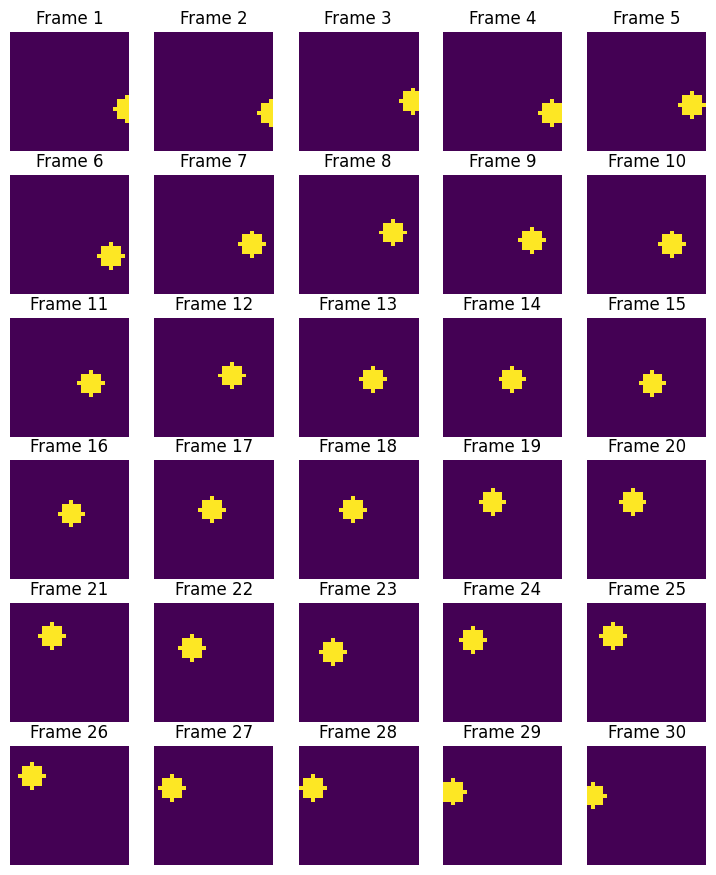

In [5]:
frames, right = build_frames(SIZE)

fig = plt.figure(figsize=(9, 7))
for i in range(SIZE):
    ax = plt.subplot(6, 5, i + 1)
    ax.imshow(frames[i])
    ax.axis('off')
    ax.set_title(f'Frame {i + 1}')
plt.subplots_adjust(top=1.3)


In [6]:
def generate_examples(size, samples):
    X, y = [], []
    for _ in range(samples):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # Number of samples, number of time steps, width, height, depth (gray scaled)
    X = np.array(X, dtype='float32').reshape(samples, size, size, size, 1)
    y = np.array(y, dtype='float32').reshape(samples, 1)
    return X, y

## Build a model

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, TimeDistributed, Activation, LSTM, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model

In [8]:
def get_uncompiled_conv_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    return Model(inputs=inputs, outputs=x)
    
def get_uncompiled_model(input_shape, conv_model):
    inputs = Input(shape=input_shape)
    conv_model_lambda = keras.layers.Lambda(lambda x: conv_model(x))
    x = TimeDistributed(conv_model_lambda)(inputs)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = LSTM(units=64)(x)
    x = Dense(1)(x)
    return Model(inputs=inputs, outputs=x)

In [9]:
conv_model = get_uncompiled_conv_model(input_shape=(SIZE, SIZE, 1))
conv_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,200 (75.00 KB)

 Trainable params: 19,008 (74.25 KB)

 Non-trainable params: 192 (768.00 B)

In [10]:
model = get_uncompiled_model(input_shape=(None, SIZE, SIZE, 1), conv_model=conv_model)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 30, 30,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 7, 7, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,089 (129.25 KB)

 Trainable params: 33,089 (129.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
X, y = generate_examples(SIZE, 10000)
X /= 255.0

In [12]:
model.compile(
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X, y,
    epochs=5,
    batch_size=64
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 234ms/step - accuracy: 0.8267 - loss: 0.2699
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 1.0000 - loss: 9.0397e-04
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 1.0000 - loss: 4.3952e-04
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 1.0000 - loss: 2.6767e-04
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 1.0000 - loss: 1.8373e-04


Ball is moving to the left
Model predicted left with accuracy of 1.00


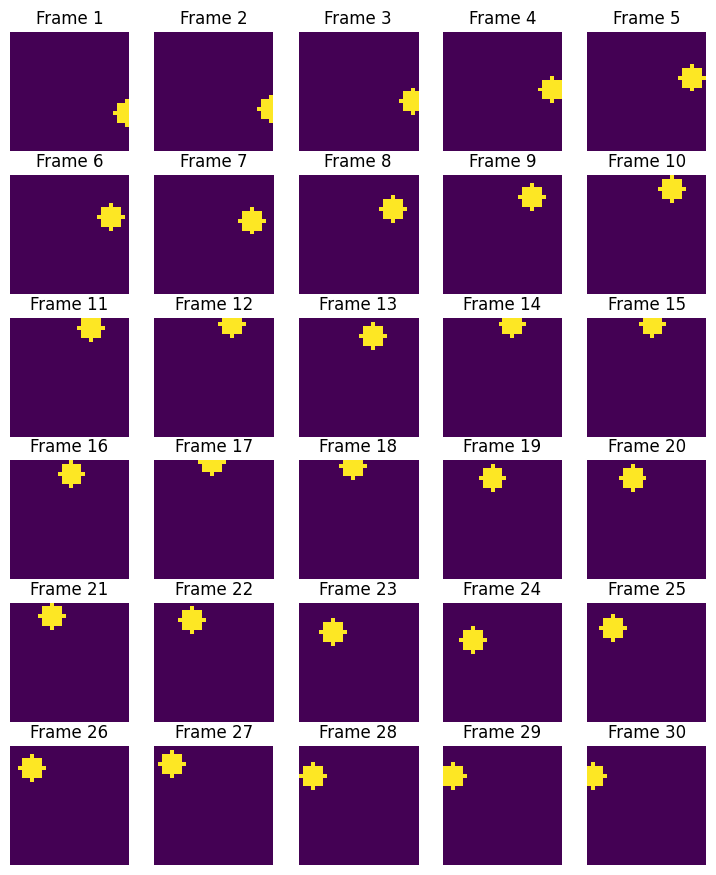

In [13]:
X, y = generate_examples(SIZE, 1)
X /= 255.0
if y[0] == 1: print('Ball is moving to the right')
else: print('Ball is moving to the left')

fig = plt.figure(figsize=(9, 7))
for i in range(SIZE):
    ax = plt.subplot(6, 5, i + 1)
    ax.imshow(X[0][i])
    ax.axis('off')
    ax.set_title(f'Frame {i + 1}')
plt.subplots_adjust(top=1.3)

y_hat = model.predict(X, verbose=0)
class_ = tf.cast(tf.sigmoid(y_hat) >= 0.5, tf.int32).numpy()[0][0]
acc_ = tf.sigmoid(y_hat)[0][0]
if class_ == 1:
    print(f'Model predicted right with accuracy of {acc_:0.2f}')
else: print(f'Model predicted left with accuracy of {1 - acc_:0.2f}')